# Load and Inspect Transaction Data

In [2]:
import pandas as pd

# Load the transaction data
transactions = pd.read_csv("/content/HI-Small_Trans.csv")

# Show basic info and head
print("🔹 Shape:", transactions.shape)
print("🔹 Columns:", transactions.columns.tolist())
print("\n🔹 Head:")
print(transactions.head())

# Check nulls
print("\n🔹 Nulls per column:")
print(transactions.isnull().sum())

# Check value counts of transaction types
print("\n🔹 Transaction types:")


🔹 Shape: (4361240, 11)
🔹 Columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']

🔹 Head:
          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1  2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2  2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3  2022/09/01 00:02         12  8000F5030       12  8000F5030   
4  2022/09/01 00:06         10  8000F5200       10  8000F5200   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          3697.34          US Dollar      3697.34        US Dollar   
1             0.01          US Dollar         0.01        US Dollar   
2         14675.57          US Dollar     14675.57        US Dollar   
3          2806.97          US Dollar      2806.97        US Dollar   
4         36682.97          US Dollar 

# Build Directed Graph and Assign Labels

In [3]:
import networkx as nx

# Remove rows with nulls in required columns
transactions_clean = transactions.dropna(subset=['Account', 'Account.1', 'Amount Paid', 'Is Laundering'])

# Convert to string IDs
transactions_clean['Account'] = transactions_clean['Account'].astype(str)
transactions_clean['Account.1'] = transactions_clean['Account.1'].astype(str)

# Build directed graph
G = nx.DiGraph()

# Add edges with weight
for _, row in transactions_clean.iterrows():
    src = row['Account']
    tgt = row['Account.1']
    amt = row['Amount Paid']
    G.add_edge(src, tgt, weight=amt)

# Assign laundering label as node attribute
# If a node appears in any laundering transaction (either side), mark it as defaulted = 1
defaulted_nodes = set(
    transactions_clean.loc[transactions_clean['Is Laundering'] == 1, 'Account']
).union(
    transactions_clean.loc[transactions_clean['Is Laundering'] == 1, 'Account.1']
)

# Assign node labels
for node in G.nodes():
    G.nodes[node]['defaulted'] = int(node in defaulted_nodes)

print(f"🔸 Total nodes: {G.number_of_nodes()}")
print(f"🔸 Total edges: {G.number_of_edges()}")
print(f"🔸 Defaulted nodes: {sum(nx.get_node_attributes(G, 'defaulted').values())}")


<ipython-input-3-9f1700248b26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_clean['Account'] = transactions_clean['Account'].astype(str)
<ipython-input-3-9f1700248b26>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_clean['Account.1'] = transactions_clean['Account.1'].astype(str)


🔸 Total nodes: 514210
🔸 Total edges: 989036
🔸 Defaulted nodes: 5221


#  Extract Graph Features for Each Node

In [4]:
import numpy as np

# Degree-based features
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Centrality measures (efficient)
pagerank = nx.pagerank(G, alpha=0.85)
degree_cent = nx.degree_centrality(G)  # fast version of centrality

# Assemble feature matrix
features_df = pd.DataFrame({
    'node_id': list(G.nodes),
    'in_degree': [in_deg.get(n, 0) for n in G.nodes],
    'out_degree': [out_deg.get(n, 0) for n in G.nodes],
    'pagerank': [pagerank.get(n, 0) for n in G.nodes],
    'degree_centrality': [degree_cent.get(n, 0) for n in G.nodes],
    'defaulted': [G.nodes[n]['defaulted'] for n in G.nodes]
})

print("🔹 Feature matrix preview:")
print(features_df.head())

print("\n🔹 Target distribution (defaulted):")
print(features_df['defaulted'].value_counts(normalize=True))


🔹 Feature matrix preview:
     node_id  in_degree  out_degree      pagerank  degree_centrality  \
0  8000EBD30         12           2  5.965956e-06           0.000027   
1  8000F4580          0           2  3.505848e-07           0.000004   
2  8000F5340         15           3  1.445260e-06           0.000035   
3  8000F4670          1           1  2.055064e-06           0.000004   
4  8000F5030         19           2  3.600916e-06           0.000041   

   defaulted  
0          0  
1          0  
2          0  
3          0  
4          1  

🔹 Target distribution (defaulted):
defaulted
0    0.989847
1    0.010153
Name: proportion, dtype: float64


# Histograms (Overall Feature Distributions)

<ipython-input-5-05426ba7a559>:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


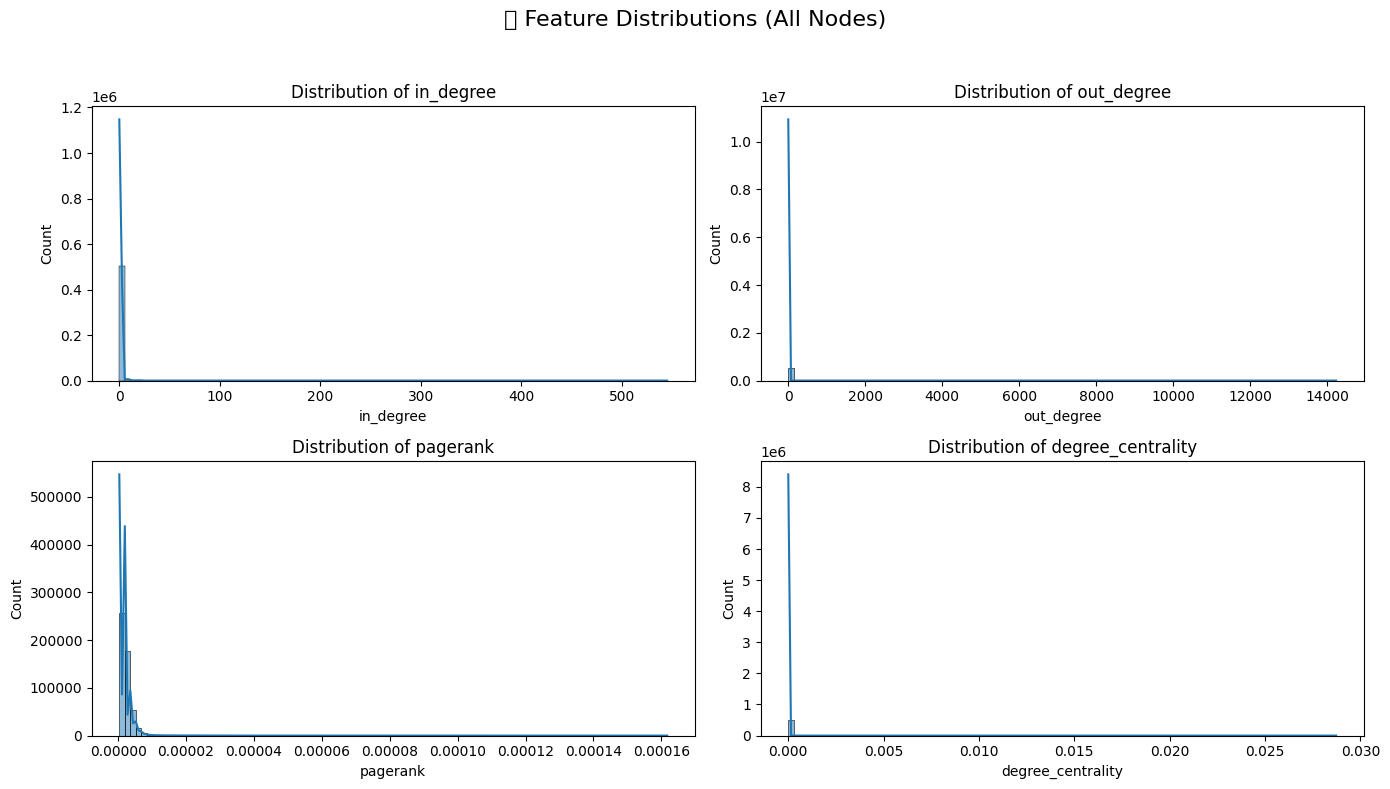

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.figure(figsize=(14, 8))
features = ['in_degree', 'out_degree', 'pagerank', 'degree_centrality']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(features_df[feature], bins=100, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

plt.suptitle("🔍 Feature Distributions (All Nodes)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Feature Comparison (Defaulted vs Not)

<ipython-input-6-73ff42915f6d>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


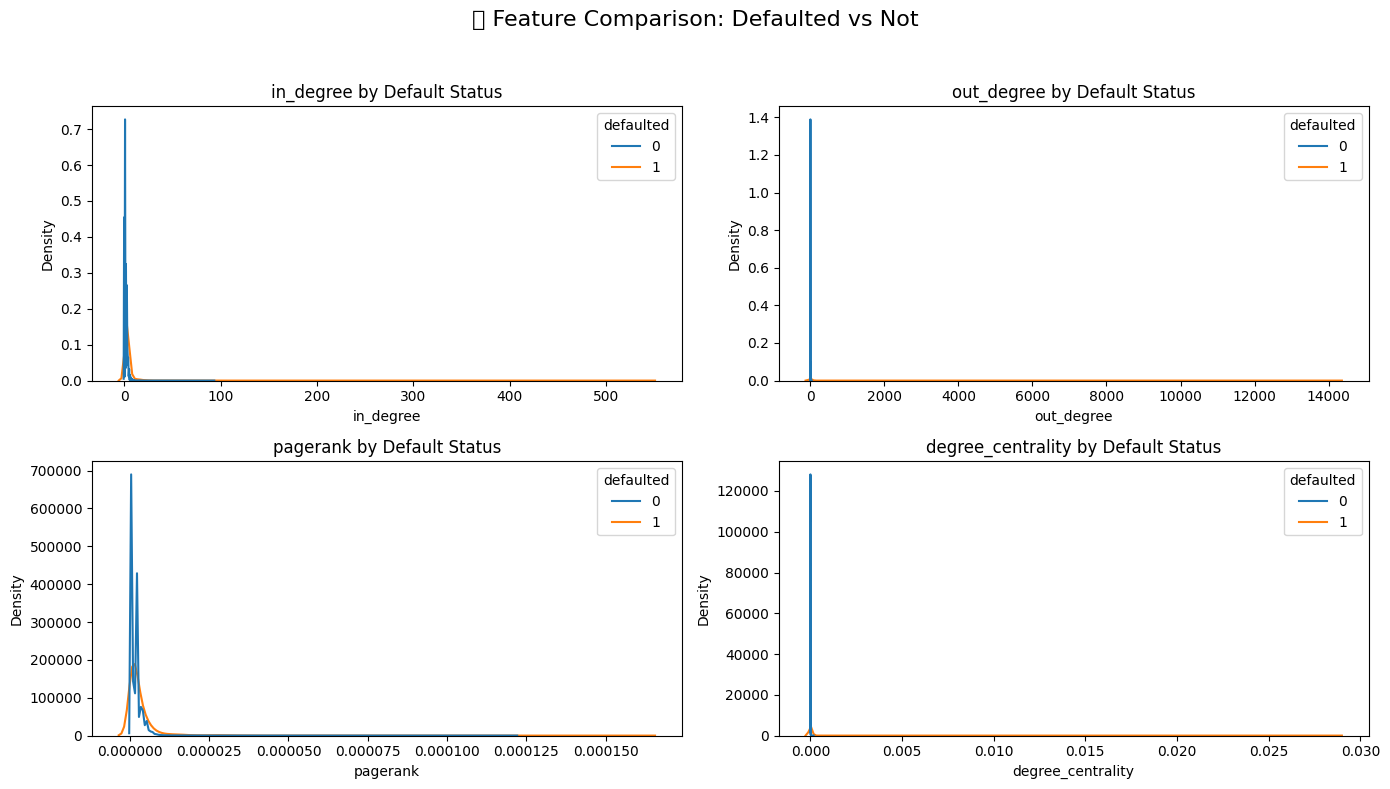

In [6]:
# Compare feature distributions for defaulted vs normal
plt.figure(figsize=(14, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=features_df, x=feature, hue='defaulted', common_norm=False)
    plt.title(f'{feature} by Default Status')
    plt.tight_layout()

plt.suptitle("📊 Feature Comparison: Defaulted vs Not", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Graph-Level Statistics

In [7]:
# 1. Basic graph structure
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

# 2. Weakly connected components (ignores edge direction)
wcc = list(nx.weakly_connected_components(G))
largest_wcc = max(wcc, key=len)
num_components = len(wcc)
largest_wcc_size = len(largest_wcc)

# 3. Diameter (on largest connected component only)
G_largest = G.subgraph(largest_wcc)
try:
    diameter = nx.diameter(G_largest.to_undirected())
except:
    diameter = "Too large to compute"

# 4. Average degree
avg_degree = sum(dict(G.degree()).values()) / num_nodes

# 5. Output
print("📊 Graph-Level Stats")
print(f"Nodes: {num_nodes}")
print(f"Edges: {num_edges}")
print(f"Graph Density: {density:.8f}")
print(f"Avg Node Degree: {avg_degree:.2f}")
print(f"Connected Components (weak): {num_components}")
print(f"Largest Component Size: {largest_wcc_size}")
print(f"Diameter (of largest component): {diameter}")

📊 Graph-Level Stats
Nodes: 514210
Edges: 989036
Graph Density: 0.00000374
Avg Node Degree: 3.85
Connected Components (weak): 121480
Largest Component Size: 360653
Diameter (of largest component): Too large to compute


# Train & Evaluate Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Select features and target
X = features_df[['in_degree', 'out_degree', 'pagerank', 'degree_centrality']]
y = features_df['defaulted']

# Split with stratification due to imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("🔹 Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.9911    0.9896    0.9903    152690
           1     0.0293    0.0340    0.0315      1411

    accuracy                         0.9809    154101
   macro avg     0.5102    0.5118    0.5109    154101
weighted avg     0.9823    0.9809    0.9816    154101

🔹 Confusion Matrix:
 [[151102   1588]
 [  1363     48]]


# SMOTE Oversampling + Retraining

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Select features and target
X = features_df[['in_degree', 'out_degree', 'pagerank', 'degree_centrality']]
y = features_df['defaulted']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train Random Forest on oversampled data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_bal, y_train_bal)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("🔍 SMOTE + RF Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

🔍 SMOTE + RF Classification Report:
               precision    recall  f1-score   support

           0     0.9934    0.7601    0.8612    152697
           1     0.0211    0.5051    0.0406      1566

    accuracy                         0.7575    154263
   macro avg     0.5073    0.6326    0.4509    154263
weighted avg     0.9835    0.7575    0.8529    154263

🔍 Confusion Matrix:
 [[116062  36635]
 [   775    791]]


# Graph Visualization with NetworkX

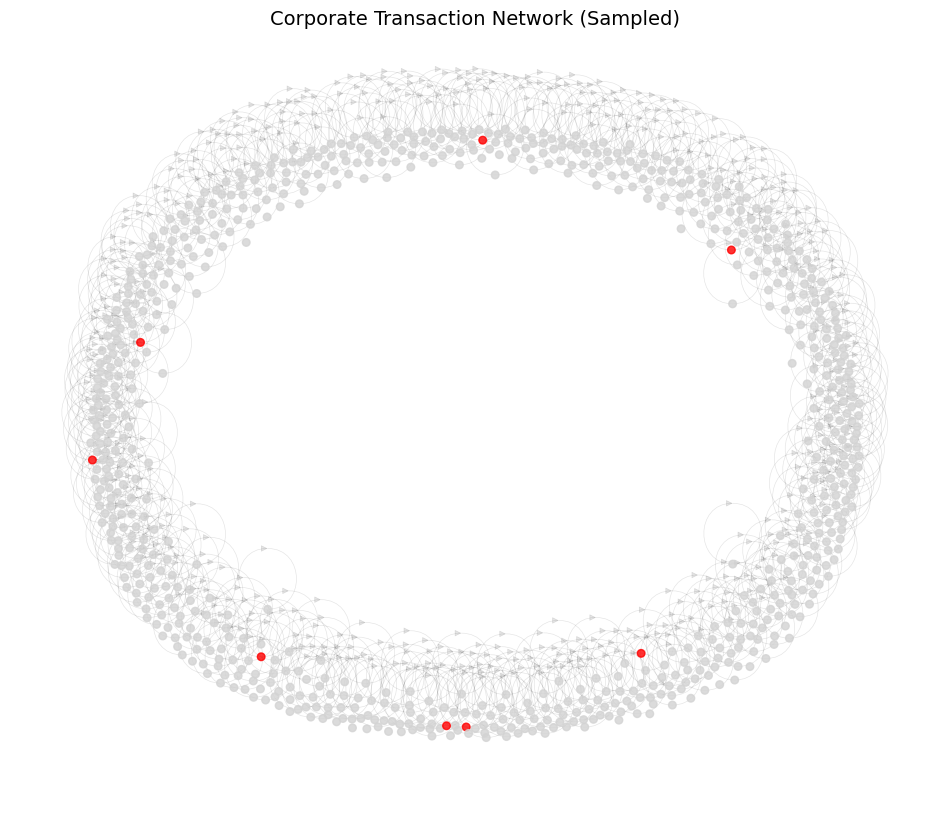

In [9]:
import matplotlib.pyplot as plt
import random

# Sample a subgraph for clarity
sub_nodes = random.sample(list(G.nodes), 800)
G_sub = G.subgraph(sub_nodes).copy()

# Color nodes: red if defaulted, gray otherwise
node_colors = [
    'red' if G_sub.nodes[n].get('defaulted', 0) == 1 else 'lightgray'
    for n in G_sub.nodes
]

# Position layout
pos = nx.spring_layout(G_sub, k=0.15, iterations=50, seed=42)

# Draw graph
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_sub, pos, node_size=30, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, alpha=0.1, width=0.5)
plt.title("Corporate Transaction Network (Sampled)", fontsize=14)
plt.axis("off")
plt.show()
